In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filePath1 = "./20240827"
def load_psd_data(filePath):
    nV,nD = 32,32
    with open(filePath,"r",encoding='shift-jis') as f: 
        infile1 = pd.read_csv(f,sep=";<SPECTRUM>|;</SPECTRUM>|;",skiprows=1,header=None, engine='python')

    [nTime1,nPsd1] = infile1.shape
    time1 = pd.to_datetime(infile1.iloc[:,0]+infile1.iloc[:,1],format="%d.%m.%Y%H:%M:%S")
    psdData = infile1.iloc[:,17:nPsd1-1].to_numpy().reshape([nTime1,nV,nD])
    psdData = np.nan_to_num(psdData)
    return time1, psdData
time1, psdData1 = load_psd_data(filePath1)

In [2]:
Delta_D = np.zeros(0)
D = np.zeros(0)
Delta_v = np.zeros(0)
v = np.zeros(0)
cn = 1
S = 54 * 10 ** -4

i=0
while cn < 10.1:
    Delta_D = np.append(Delta_D,0.125)
    D = np.append(D,0.062+0.125*i)
    Delta_v = np.append(Delta_v,0.100)
    v = np.append(v,0.050+0.100*i)
    cn+=1
    i+=1

i=0
while cn < 15.1:
    Delta_D = np.append(Delta_D,0.250)
    D = np.append(D,1.375+0.250*i)
    Delta_v = np.append(Delta_v,0.200)
    v = np.append(v,1.100+0.200*i)
    cn+=1
    i+=1

i=0
while cn < 20.1:
    Delta_D = np.append(Delta_D,0.500) 
    D = np.append(D,2.750+0.5*i) 
    Delta_v = np.append(Delta_v,0.400)
    v = np.append(v,2.200+0.400*i)
    cn+=1
    i+=1

i=0
while cn < 25.1:
    Delta_D = np.append(Delta_D,1.000)
    D = np.append(D,5.500+1.0*i)  
    Delta_v = np.append(Delta_v,0.800)
    v = np.append(v,4.4+0.800*i)
    cn+=1
    i+=1

i=0
while cn < 30.1:
    Delta_D = np.append(Delta_D,2.000)
    D = np.append(D,11.000+2.0*i)
    Delta_v = np.append(Delta_v,1.600)
    v = np.append(v,8.8+1.6*i)
    cn+=1
    i+=1

i=0
while cn < 32.1:
    Delta_D = np.append(Delta_D,3.000) 
    D = np.append(D,21.5+3.0*i)
    Delta_v = np.append(Delta_v,3.200)
    v = np.append(v,17.6+3.2*i)
    i+=1
    cn+=1

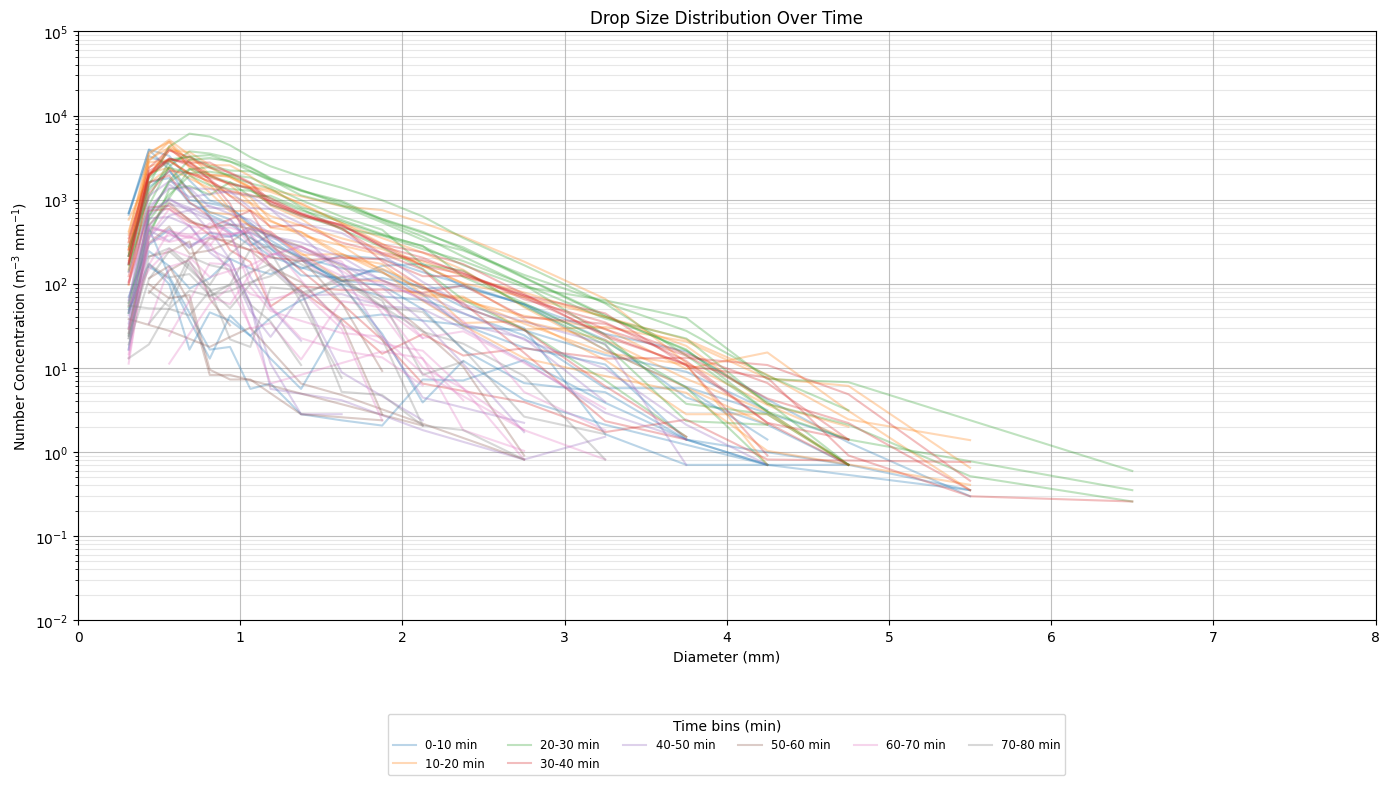

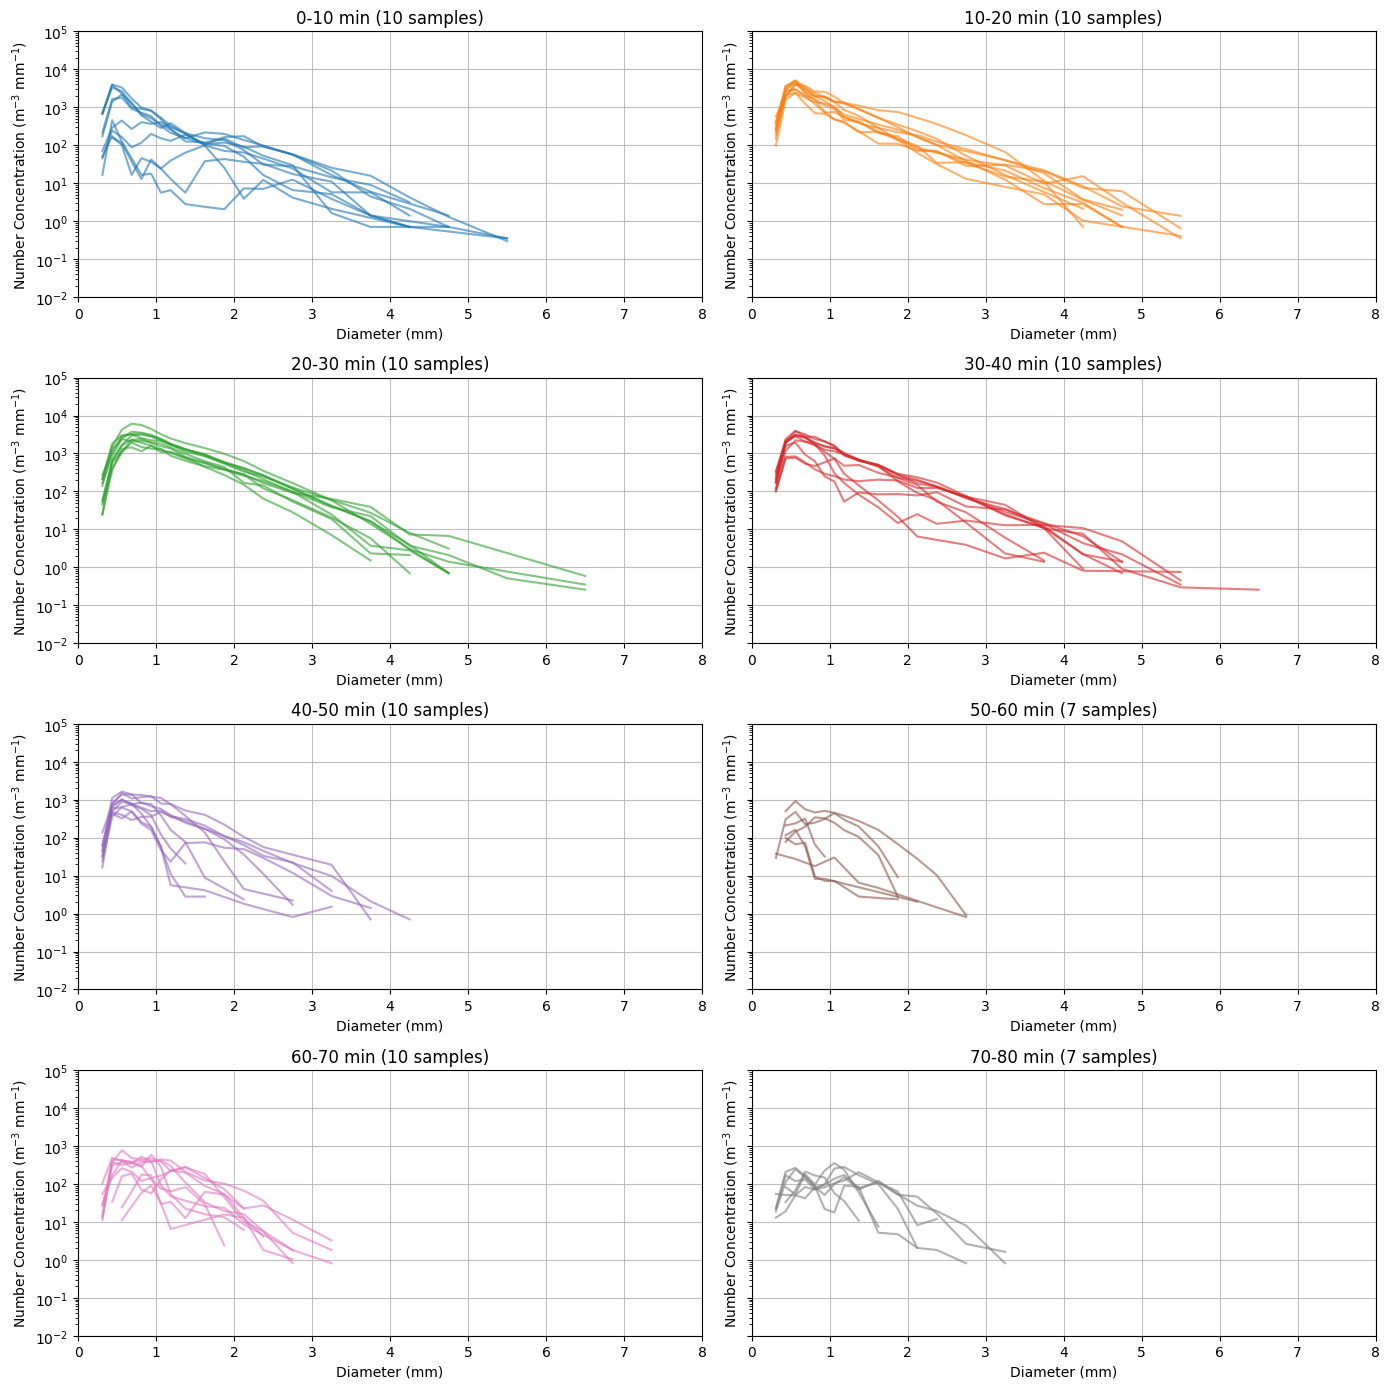

In [3]:
def compute_N(psdData):
    """
    psdData (n_time, nV, nD) から N(t, D) を計算して返します。
    戻り値: N_all (n_time, nD)
    """
    n_time = psdData.shape[0]
    N_all = np.zeros((n_time, D.size))
    for t in range(n_time):
        N = (psdData[t,:,:] / (S * 60 * v.reshape(-1,1))).sum(axis=0) / Delta_D
        N_all[t,:] = N
    return N_all

def distplot(N_all, time_array, time_bin=10):
    """
    既に計算済みの N_all (n_time, nD) を受け取り、オーバーレイ表示します。
    time_bin: 凡例用の時間ビン幅(分)
    """
    if len(time_array) == 0 or N_all.shape[0] == 0:
        print("No data to plot (empty after filtering)")
        return
    plt.figure(figsize=(14,8))
    base_time = time_array.iloc[0]
    cmap = plt.get_cmap("tab10")
    seen_bins = set()
    for t in range(N_all.shape[0]):
        N = N_all[t]
        minutes = int((time_array.iloc[t] - base_time).total_seconds() // 60)
        bin_idx = minutes // time_bin
        color = cmap(bin_idx % cmap.N)
        if bin_idx not in seen_bins:
            label = f"{bin_idx*time_bin}-{(bin_idx+1)*time_bin} min"
            seen_bins.add(bin_idx)
        else:
            label = None
        plt.plot(D[N>0], N[N>0], color=color, alpha=0.3, label=label)

    plt.yscale("log")
    plt.xlabel("Diameter (mm)")
    plt.ylabel("Number Concentration (m$^{-3}$ mm$^{-1}$)")
    plt.xlim(0,8)
    plt.ylim(1e-2,1e5)
    plt.title("Drop Size Distribution Over Time")
    n_bins = len(seen_bins) if 'seen_bins' in locals() else 1
    plt.legend(ncol=n_bins if n_bins<=6 else 6, loc="upper center", bbox_to_anchor=(0.5, -0.15), fontsize="small", title="Time bins (min)")
    plt.grid(which="major", alpha=0.8)
    plt.grid(which="minor", alpha=0.3)
    plt.tight_layout()
    plt.show()
    return

def distplot_by_10min(N_all, time_array, bin_minutes=10, ncols=4, figsize=(12,8), sharey=True):
    """
    データを bin_minutes ごとにグループ化し、各ビンを別々のサブプロットに表示します。
    - N_all: ndarray (n_time, nD)
    - time_array: pd.Series - 時刻データ
    - bin_minutes: ビン幅(分単位、デフォルト 10)
    - ncols: サブプロットの列数
    - sharey: y 軸を共有するかどうか
    """
    if len(time_array) == 0 or N_all.shape[0] == 0:
        print("No data to plot (empty after filtering)")
        return
    base_time = time_array.iloc[0]
    minutes_arr = np.array([int((t - base_time).total_seconds() // 60) for t in time_array])
    bin_idx_arr = minutes_arr // int(bin_minutes)
    bins = np.unique(bin_idx_arr)
    n_bins = len(bins)
    ncols = max(1, int(ncols))
    nrows = (n_bins + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=sharey)
    axes_flat = axes.flatten()
    cmap = plt.get_cmap("tab10")
    for i, b in enumerate(bins):
        ax = axes_flat[i]
        idxs = np.where(bin_idx_arr == b)[0]
        for t in idxs:
            N = N_all[t]
            ax.plot(D[N>0], N[N>0], color=cmap(b % cmap.N), alpha=0.6)
        start_min = int(b * bin_minutes)
        end_min = int((b+1) * bin_minutes)
        ax.set_title(f"{start_min}-{end_min} min ({len(idxs)} samples)")
        ax.set_yscale("log")
        ax.set_xlim(0,8)
        ax.set_ylim(1e-2,1e5)
        ax.set_xlabel("Diameter (mm)")
        ax.set_ylabel("Number Concentration (m$^{-3}$ mm$^{-1}$)")
        ax.grid(which="major", alpha=0.8)
    for j in range(n_bins, len(axes_flat)):
        axes_flat[j].set_visible(False)
    plt.tight_layout()
    plt.show()
    return

# N を先に計算してから関数に渡す(例)
N_all = compute_N(psdData1)
distplot(N_all, time1)
distplot_by_10min(N_all, time1, bin_minutes=10, ncols=2, figsize=(14,14))


(74, 32)
[4.55260891e+00 1.04254885e+01 1.53550882e+01 1.11880264e+01
 7.51952829e+00 4.31752362e+01 3.43214391e+01 2.78541222e+01
 1.51320911e+01 2.19577984e+01 2.40510367e+01 2.85903214e+01
 4.99728607e+01 4.89694131e+01 5.55713439e+01 4.04366485e+01
 4.83859668e+01 2.23239688e+01 5.60558820e+01 1.06291791e+02
 1.19002019e+02 8.63217477e+01 7.38405962e+01 4.77268972e+01
 8.32447492e+01 8.97253233e+01 8.34752658e+01 6.90275260e+01
 4.77792320e+01 2.99625253e+01 2.91806714e+01 5.80399852e+01
 5.37006044e+01 4.98384914e+01 2.54167948e+01 9.49368594e+00
 2.48117397e+01 3.20082005e+01 4.90603093e+01 4.57476073e+01
 2.80516478e+01 7.78725886e+00 2.49276666e+00 1.02303134e+00
 6.74650515e-01 1.14331641e+00 8.40711566e+00 1.86779706e+01
 1.46722902e+01 8.49308945e+00 7.02576467e+00 3.05694943e+00
 1.89803810e+00 1.29931016e-01 8.87533563e-02 2.52358492e-01
 9.09908374e-02 9.28650193e-01 2.32760294e+00 3.87648404e+00
 5.40504663e+00 1.01243644e+01 9.66013060e+00 3.71597687e+00
 1.64507893e+00

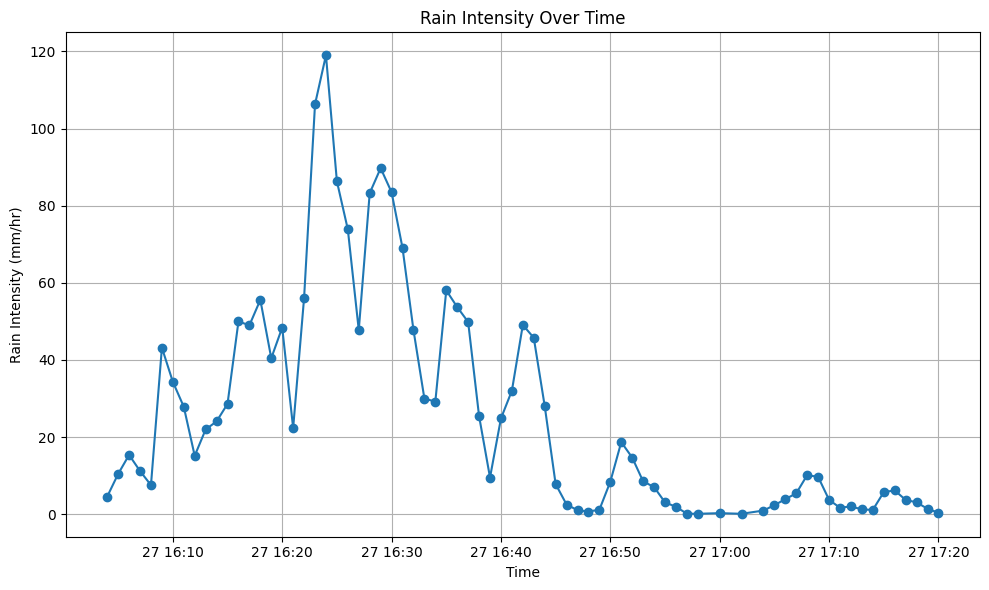

In [4]:
# 時刻毎の降水強度の計算
def culculate_rain_intensity(psdData):
    """
    時刻毎の降水強度 (mm/hr) を計算して返します。
    引数：
    - psdData: ndarray (n_time,nV,nD)
    戻り値：
    - rain_intensity: ndarray (n_time) - 降水強度 (mm/hr)
    """
    # 降水強度の計算
    # 単位に注意
    # 粒径の落下速度を計算
    u = culculate_u(psdData)
    # 粒径ごとの数密度を計算
    N_all = compute_N(psdData)
    rain_intensity = (N_all * (D ** 3) * u * Delta_D).sum(axis = 1) * np.pi * 6 * 1e-4
    print(N_all.shape)
    return rain_intensity

def culculate_u(psdData):
    """
    直径 D (mm) に対する落下速度 u (m/s) を計算して返します。
    引数：
    - psdData: ndarray (n_time,nV,nD)
    戻り値：
    - u: ndarray (n_time,nD) - 各時刻・各径の平均落下速度 (m/s)
    実装：各径について速度ビン `v` を重みとして平均を計算します。
    """
    u = np.zeros((psdData.shape[0], psdData.shape[2]))
    for t in range(psdData.shape[0]):
        for d in range(psdData.shape[2]):
            psd_slice = psdData[t,:,d]
            total_count = psd_slice.sum()
            if total_count > 0:
                weighted_sum = (psd_slice * v).sum()
                u[t,d] = weighted_sum / total_count
            else:
                u[t,d] = 0.0  # データがない場合は速度を0に設定
    return u

rain_intensity = culculate_rain_intensity(psdData1)
print(rain_intensity)
# 降水強度のプロット
def plot_rain_intensity(rain_intensity, time_array):
    plt.figure(figsize=(10,6))
    plt.plot(time_array, rain_intensity, marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Rain Intensity (mm/hr)")
    plt.title("Rain Intensity Over Time")
    plt.grid()
    plt.tight_layout()
    plt.show()
    return
plot_rain_intensity(rain_intensity, time1)


[[0.    0.    1.5   ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    1.125 ... 0.    0.    0.   ]
 ...
 [0.    0.    1.9   ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


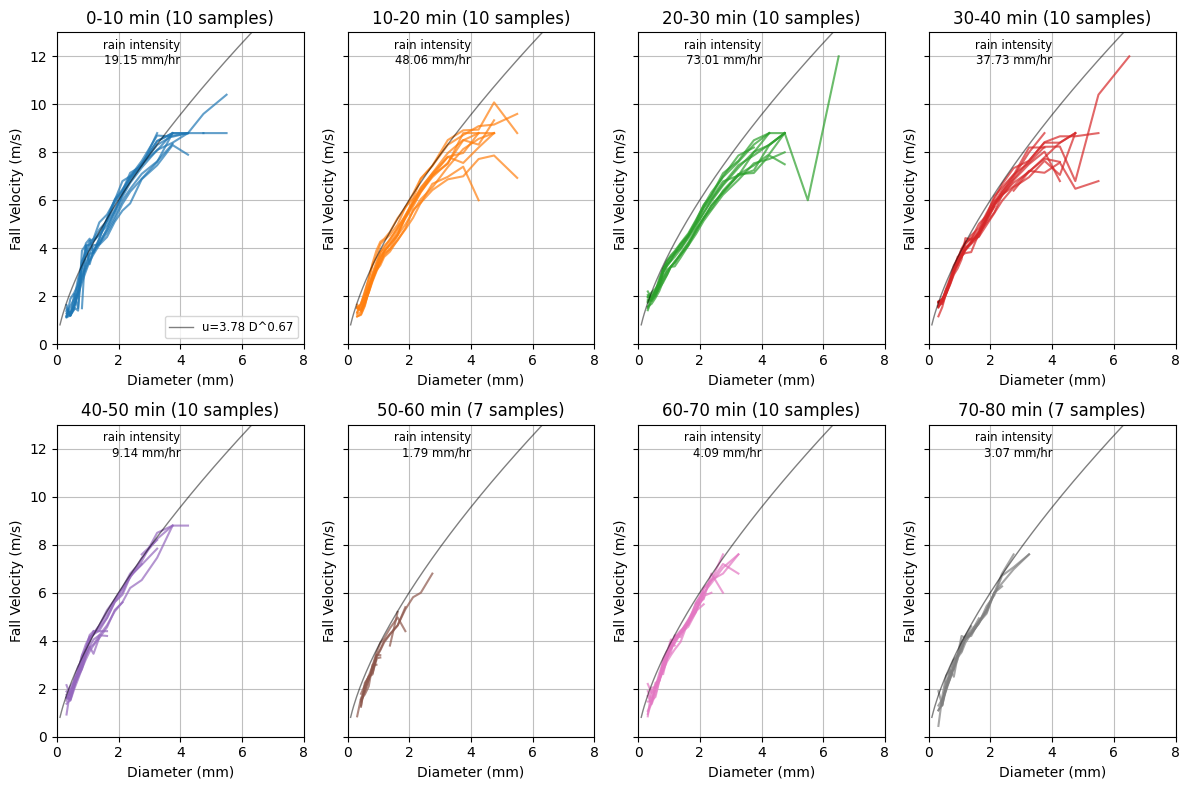

In [5]:
u = culculate_u(psdData1)
print(u)
def culc_avg_rain_intensity(rain_intensity, time_array, bin_minutes=10):
    """
    降水強度データを指定したビン幅で平均化します。
    引数：
    - rain_intensity: ndarray (n_time) - 降水強度 (mm/hr)
    - time_array: pd.Series - 時刻データ
    - bin_minutes: ビン幅(分単位、デフォルト 10)
    戻り値：
    - avg_rain_intensity: ndarray (n_bins) - 各ビンの平均降水強度
    - bin_centers: ndarray (n_bins) - 各ビンの中心時刻(分単位)
    """
    if len(time_array) == 0 or len(rain_intensity) == 0:
        print("No data to compute average rain intensity (empty after filtering)")
        return np.array([]), np.array([])
    base_time = time_array.iloc[0]
    minutes_arr = np.array([int((t - base_time).total_seconds() // 60) for t in time_array])
    bin_idx_arr = minutes_arr // int(bin_minutes)
    bins = np.unique(bin_idx_arr)
    avg_rain_intensity = []
    bin_centers = []
    for b in bins:
        idxs = np.where(bin_idx_arr == b)[0]
        avg_intensity = rain_intensity[idxs].mean()
        avg_rain_intensity.append(avg_intensity)
        center_min = (b + 0.5) * bin_minutes
        bin_centers.append(center_min)
    return np.array(avg_rain_intensity), np.array(bin_centers)
avg_rain_intensity, bin_centers = culc_avg_rain_intensity(rain_intensity, time1, bin_minutes=10)

def display_u_by_10min(u, time_array, rain_intensity, bin_minutes=10, ncols=4, figsize=(12,8), sharey=True):
    # 0 to nan
    if len(time_array) == 0 or u.shape[0] == 0:
        print("No data to plot u (empty after filtering)")
        return
    u = np.where(u == 0, np.nan, u)
    avg_rain_intensity, _ = culc_avg_rain_intensity(rain_intensity, time_array, bin_minutes=bin_minutes)
    if len(avg_rain_intensity) == 0:
        print("No data to plot u (no rain intensity data)")
        return
    base_time = time_array.iloc[0]
    minutes_arr = np.array([int((t - base_time).total_seconds() // 60) for t in time_array])
    bin_idx_arr = minutes_arr // int(bin_minutes)
    bins = np.unique(bin_idx_arr)
    n_bins = len(bins)
    ncols = max(1, int(ncols))
    nrows = (n_bins + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=sharey)
    axes_flat = axes.flatten()
    cmap = plt.get_cmap("tab10")
    for i, b in enumerate(bins):
        ax = axes_flat[i]
        idxs = np.where(bin_idx_arr == b)[0]
        for t in idxs:
            ax.plot(D, u[t,:], color=cmap(b % cmap.N), alpha=0.7)
        # 理論式をプロット: u = 3.78 * D^0.67
        D_theo = np.linspace(0.1, 10, 200)
        u_theo = 3.78 * D_theo ** 0.67
        if i == 0:
            ax.plot(D_theo, u_theo, color='k', linewidth=1, label='u=3.78 D^0.67', alpha = 0.5)
            ax.legend(fontsize='small')
        else:
            ax.plot(D_theo, u_theo, color='k', linewidth=1, alpha=0.5)
        # 降水強度の平均値も表示
        avg_intensity = avg_rain_intensity[i]
        ax.text(0.5, 0.9, f"rain intensity\n{avg_intensity:.2f} mm/hr", transform=ax.transAxes, fontsize='small', ha='right')
        start_min = int(b * bin_minutes)
        end_min = int((b+1) * bin_minutes)
        ax.set_title(f"{start_min}-{end_min} min ({len(idxs)} samples)")
        ax.set_xlabel("Diameter (mm)")
        ax.set_ylabel("Fall Velocity (m/s)")
        ax.grid(which="major", alpha=0.8)
        ax.set_xlim(0, 8)
        ax.set_ylim(0, 13)
    for j in range(n_bins, len(axes_flat)):
        axes_flat[j].set_visible(False)
    plt.tight_layout()
    plt.show()
    return
display_u_by_10min(u, time1, rain_intensity)


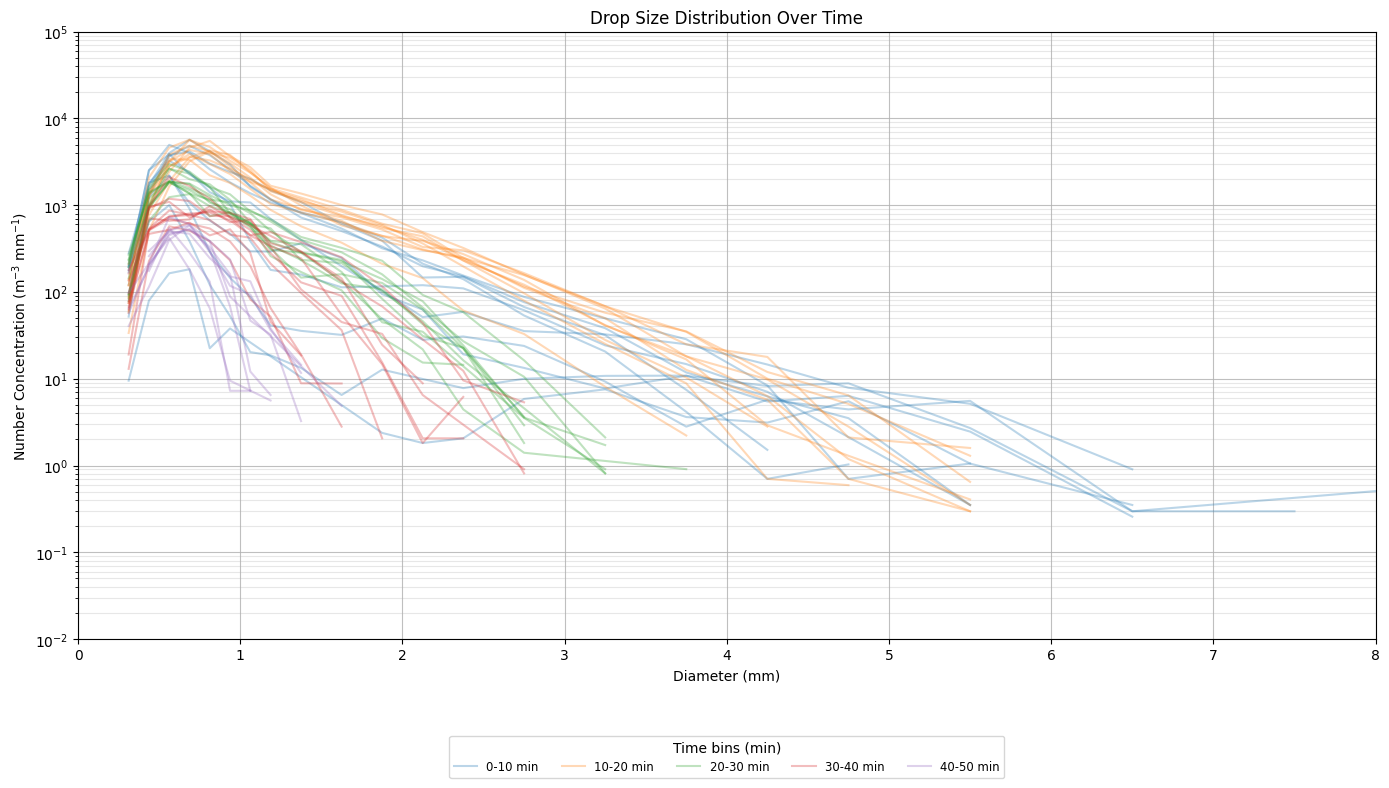

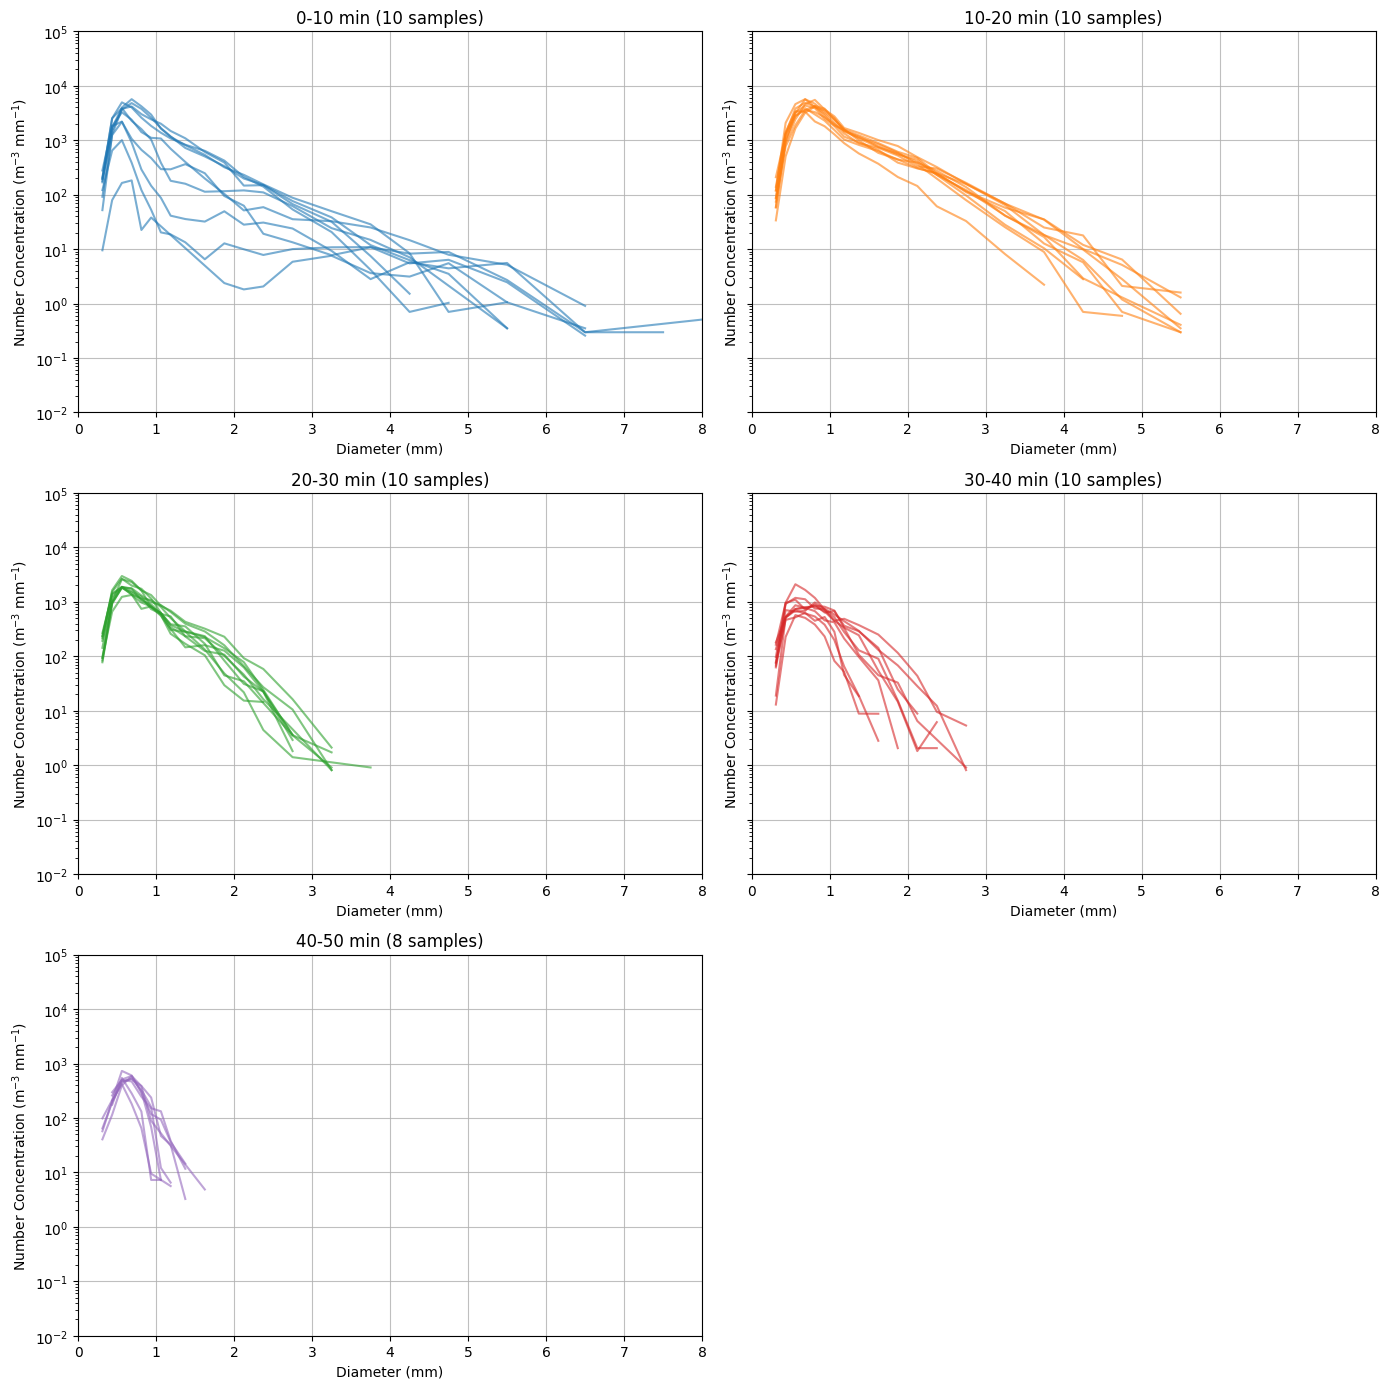

(48, 32)


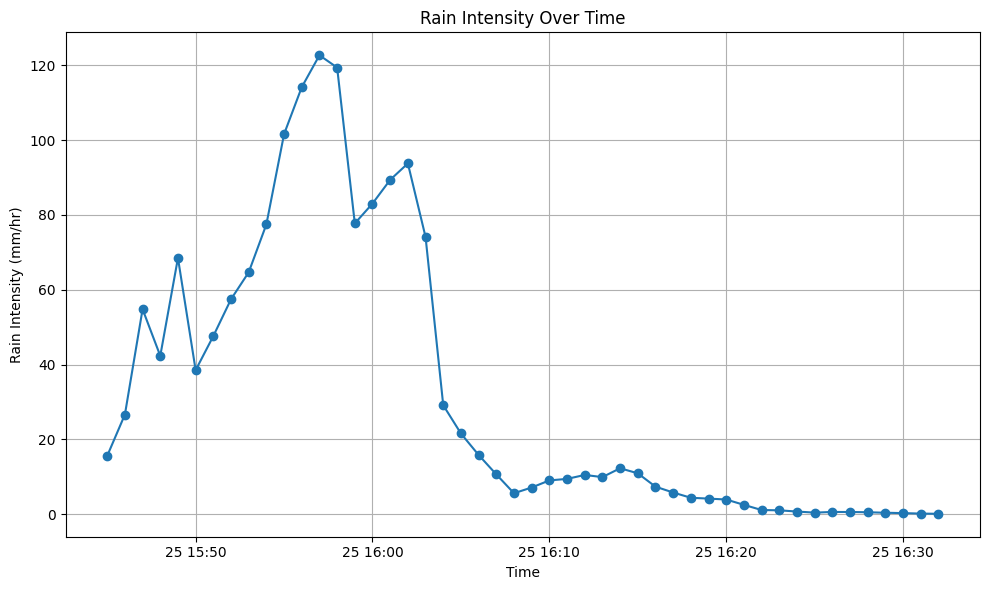

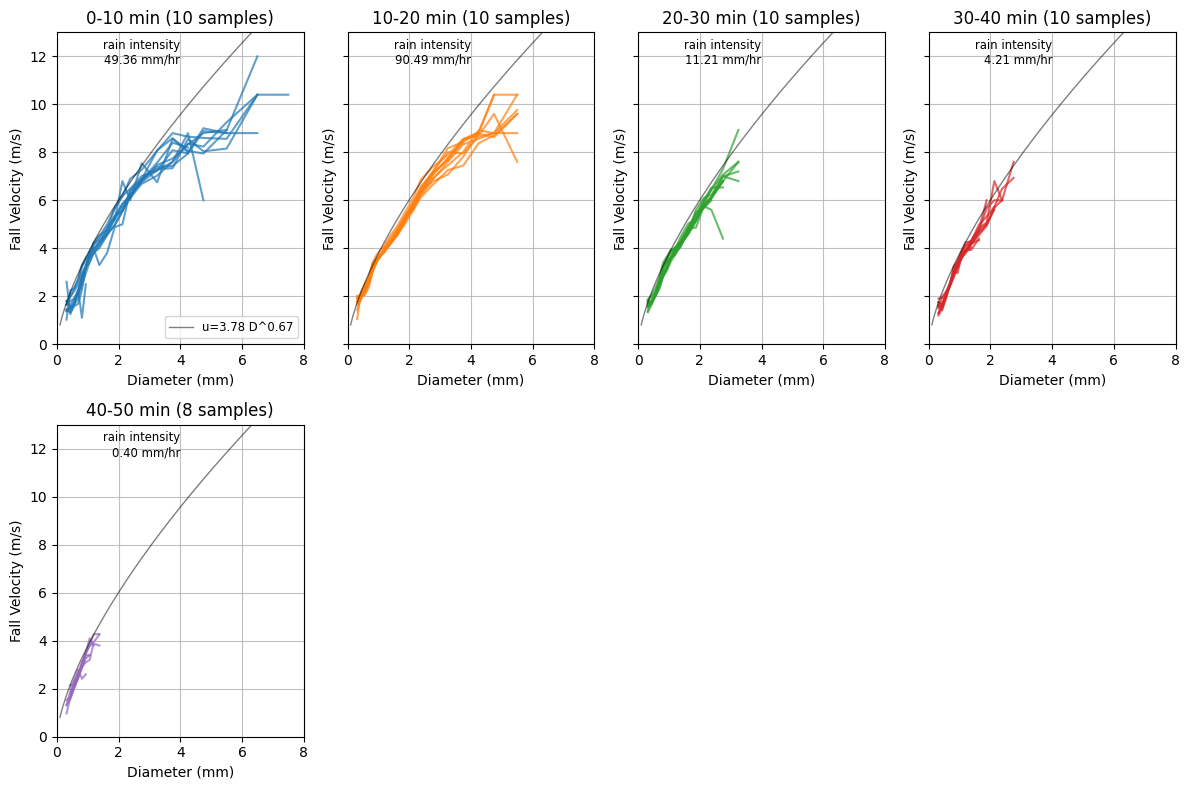

In [6]:
# ほかの日のもやってみる
filePath2 = "./202508"
time2, psdData2 = load_psd_data(filePath2)
N_all2 = compute_N(psdData2)

# 表示する期間を絞る
start_time = pd.to_datetime("2025-08-25 00:00:00")
end_time = pd.to_datetime("2025-08-26 00:00:00")
time_mask = (time2 >= start_time) & (time2 < end_time)
psdData2 = psdData2[time_mask]
N_all2 = N_all2[time_mask]
time2 = time2[time_mask].reset_index(drop=True)

distplot(N_all2, time2)
distplot_by_10min(N_all2, time2, bin_minutes=10, ncols=2, figsize=(14,14))
rain_intensity2 = culculate_rain_intensity(psdData2)
plot_rain_intensity(rain_intensity2, time2)
u2 = culculate_u(psdData2)
display_u_by_10min(u2, time2, rain_intensity2)


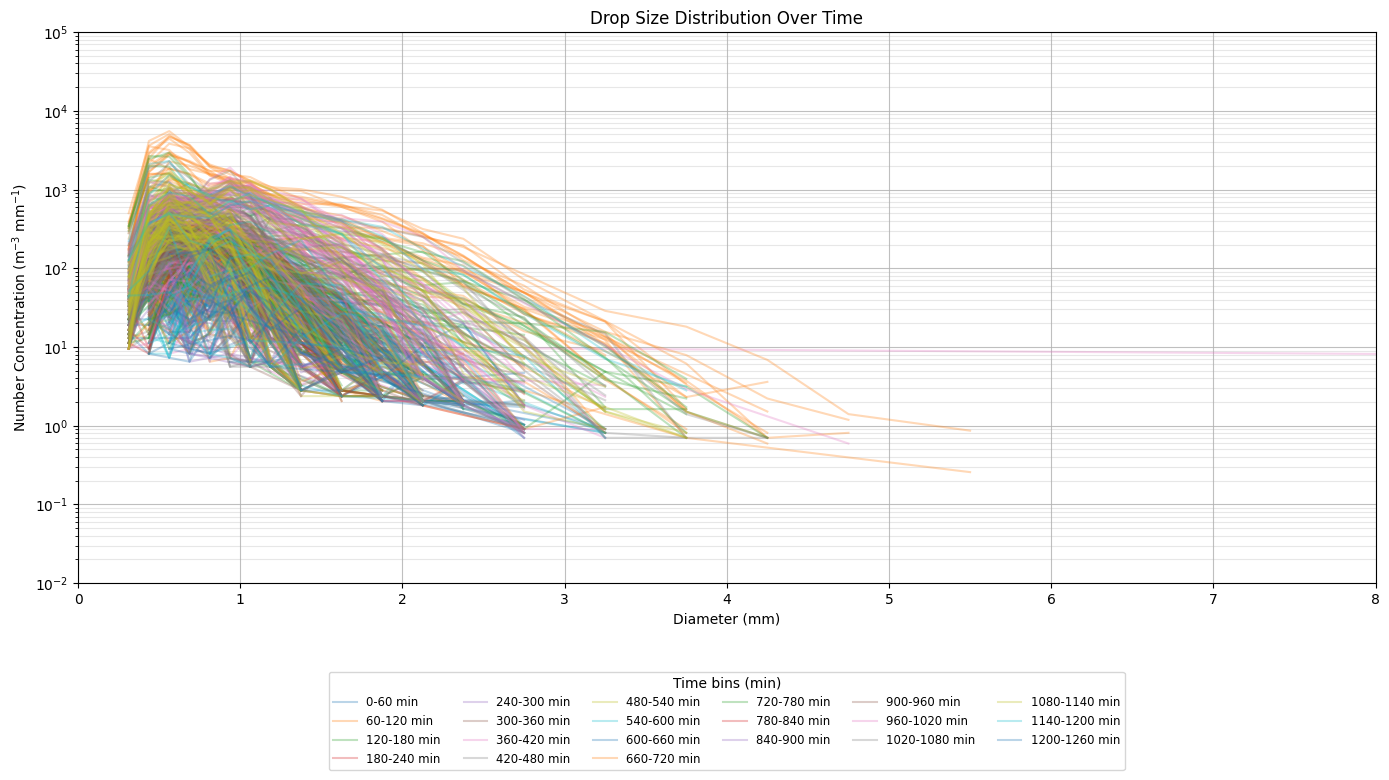

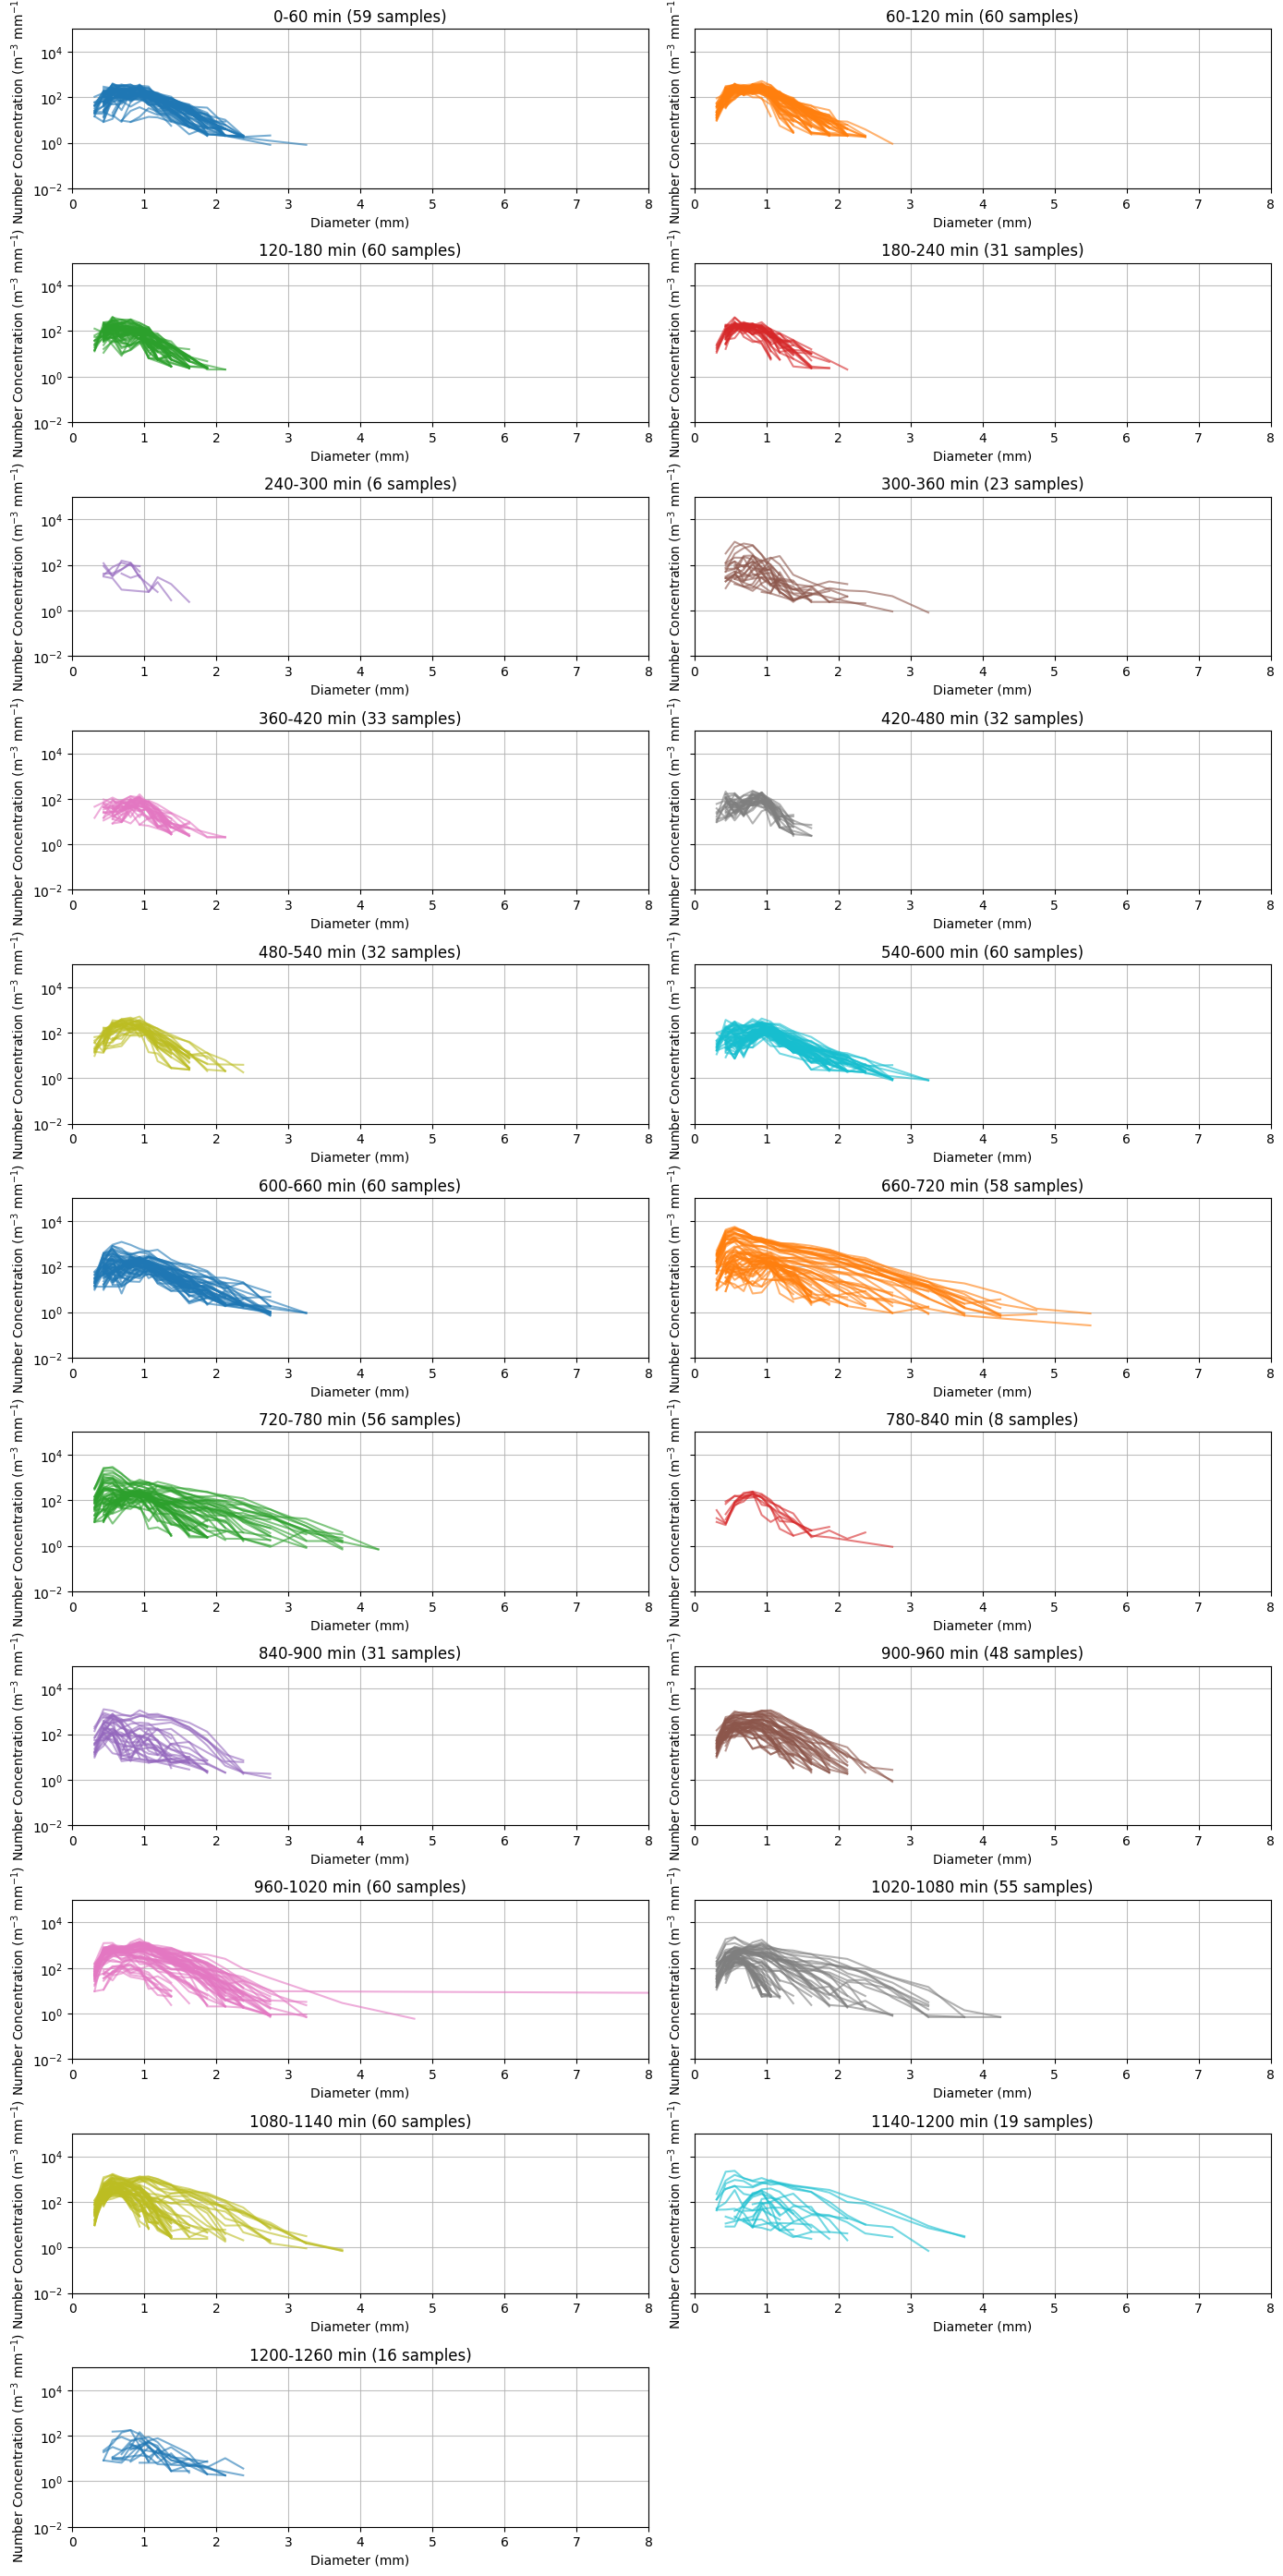

(867, 32)


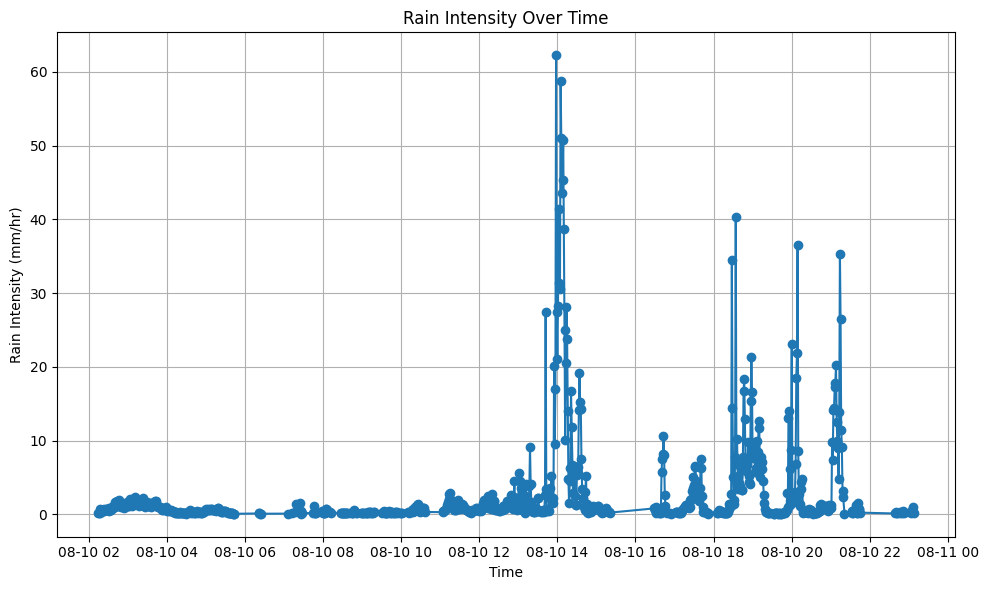

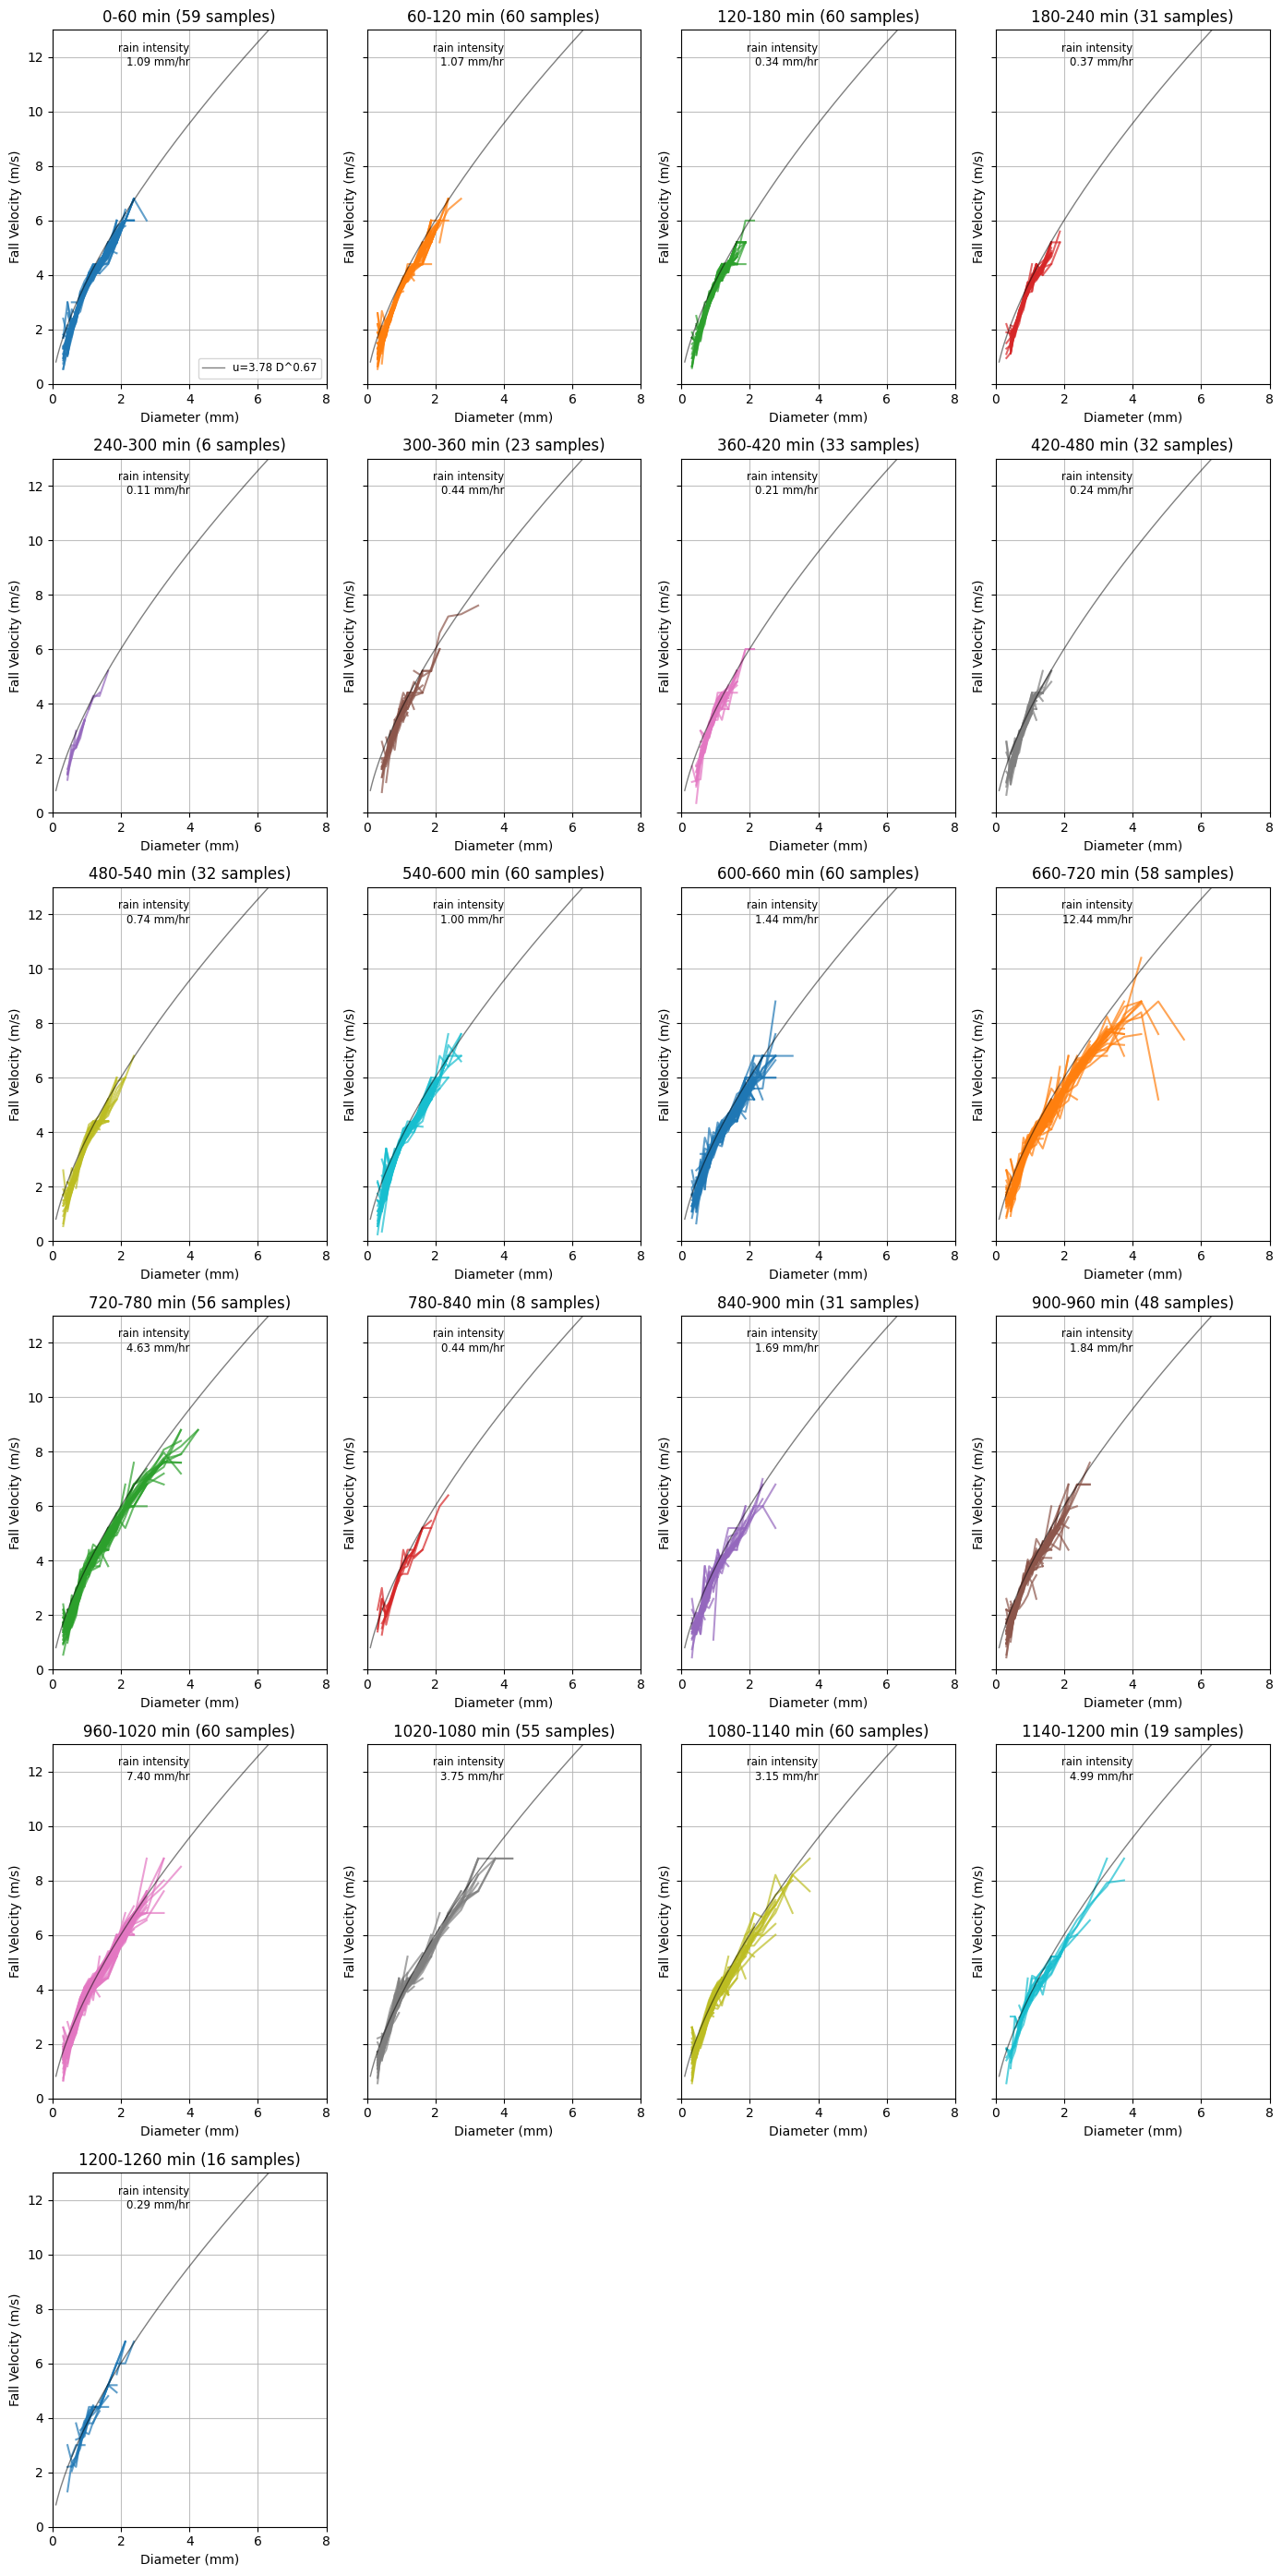

In [7]:
# 202508の別の期間を解析
filePath3 = "./202508"
time3, psdData3 = load_psd_data(filePath3)
N_all3 = compute_N(psdData3)

# 表示する期間を絞る
start_time = pd.to_datetime("2025-08-10 00:00:00")
end_time = pd.to_datetime("2025-08-11 00:00:00")
time_mask = (time3 >= start_time) & (time3 < end_time)
psdData3 = psdData3[time_mask]
N_all3 = N_all3[time_mask]
time3 = time3[time_mask].reset_index(drop=True)

time_bin3 = 60
distplot(N_all3, time3, time_bin=time_bin3)
distplot_by_10min(N_all3, time3, bin_minutes=time_bin3, ncols=2, figsize=(14,28))
rain_intensity3 = culculate_rain_intensity(psdData3)
plot_rain_intensity(rain_intensity3, time3)
u3 = culculate_u(psdData3)
display_u_by_10min(u3, time3, rain_intensity3, bin_minutes=time_bin3, figsize=(14,28))